<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/%EB%82%B4%EB%B6%80%EC%A0%80%ED%95%AD%EA%B5%AC%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('/content/drive/MyDrive/M0000_0009_0019_20170109075822_cell50.csv', encoding='utf8')
df

,Volt,Temp,Resistance
0,4.49,-20,0.466
1,4.49,-20,0.453
2,4.48,-20,0.458
3,4.48,-20,0.458
4,4.47,-20,0.465
...,...,...,...
8967,4.47,-20,0.777
8968,4.45,-20,0.776
8969,4.46,-20,0.777
8970,4.46,-20,0.777


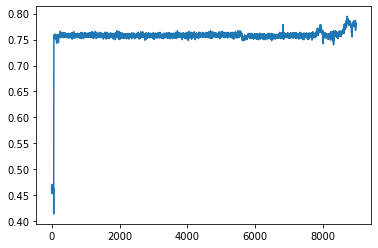

In [44]:
df['Resistance'].plot()

In [12]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scale_cols = ['Volt', 'Temp', 'Resistance']
# df_scaled = scaler.fit_transform(df[scale_cols])

# df_scaled = pd.DataFrame(df_scaled)
# df_scaled.columns = scale_cols

# print(df_scaled)

          Volt  Temp  Resistance
0     0.937500   0.0    0.136483
1     0.937500   0.0    0.102362
2     0.916667   0.0    0.115486
3     0.916667   0.0    0.115486
4     0.895833   0.0    0.133858
...        ...   ...         ...
8967  0.895833   0.0    0.952756
8968  0.854167   0.0    0.950131
8969  0.875000   0.0    0.952756
8970  0.875000   0.0    0.952756
8971  0.875000   0.0    0.960630

[8972 rows x 3 columns]


In [17]:
TEST_SIZE = 1794

In [18]:
train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]

In [58]:
test

,Resistance
7178,0.760
7179,0.758
7180,0.754
7181,0.754
7182,0.759
...,...
8967,0.777
8968,0.776
8969,0.777
8970,0.777


In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp']
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.14246575],
       [0.10684932],
       [0.12054795],
       ...,
       [0.93972603],
       [0.94520548],
       [0.94794521]])

In [61]:
test_scaled = scaler.fit_transform(test)
test_scaled


array([[0.36363636],
       [0.32727273],
       [0.25454545],
       ...,
       [0.67272727],
       [0.67272727],
       [0.72727273]])

In [64]:
test_scaled.shape

(1794, 1)

In [65]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [69]:
feature_cols = ['Volt', 'Temp']
label_cols = ['Resistance']

train_feature = train
train_label = train[label_cols]
test_feature = test
test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)


test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((1774, 20, 1), (1774, 1))

In [70]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [71]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('C:/Users/wlsrm/data', 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
358/358 [==============================] - 4s 8ms/step - loss: 0.1685 - val_loss: 4.7632e-05

Epoch 00001: val_loss improved from inf to 0.00005, saving model to C:/Users/wlsrm/data/tmp_checkpoint.h5
Epoch 2/200
358/358 [==============================] - 3s 8ms/step - loss: 7.9229e-05 - val_loss: 4.6004e-05

Epoch 00002: val_loss improved from 0.00005 to 0.00005, saving model to C:/Users/wlsrm/data/tmp_checkpoint.h5
Epoch 3/200
358/358 [==============================] - 3s 8ms/step - loss: 6.0717e-05 - val_loss: 4.5307e-05

Epoch 00003: val_loss improved from 0.00005 to 0.00005, saving model to C:/Users/wlsrm/data/tmp_checkpoint.h5
Epoch 4/200
358/358 [==============================] - 3s 8ms/step - loss: 9.1588e-05 - val_loss: 4.4852e-05

Epoch 00004: val_loss improved from 0.00005 to 0.00004, saving model to C:/Users/wlsrm/data/tmp_checkpoint.h5
Epoch 5/200
358/358 [==============================] - 3s 8ms/step - loss: 6.4757e-05 - val_loss: 4.2719e-05

Epoch 00005: val_l

In [72]:
model.load_weights(filename)

pred = model.predict(test_feature)

In [73]:
pred

array([[0.7610782 ],
       [0.76143   ],
       [0.76128125],
       ...,
       [0.7771856 ],
       [0.77724105],
       [0.7772973 ]], dtype=float32)

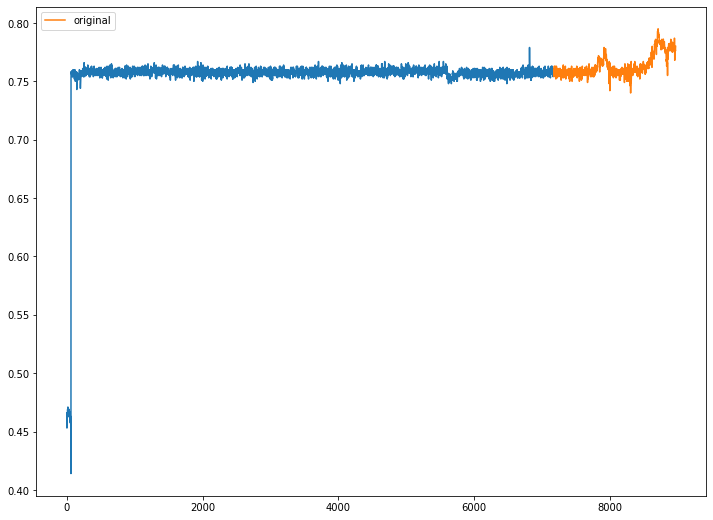

In [74]:
# train = df.loc[:7178, ['Resistance']]
# test = df.loc[7178:, ['Resistance']]
# pred2 = 
plt.figure(figsize=(12, 9))
plt.plot(train)
plt.plot(test, label='original')
# plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [52]:
test

,Resistance
7178,0.760
7179,0.758
7180,0.754
7181,0.754
7182,0.759
...,...
8967,0.777
8968,0.776
8969,0.777
8970,0.777


In [76]:
test_label

array([[0.762],
       [0.76 ],
       [0.759],
       ...,
       [0.777],
       [0.777],
       [0.78 ]])

In [85]:
test_label2 = scaler.inverse_transform(test_label)
test_label2

array([[0.78191 ],
       [0.7818  ],
       [0.781745],
       ...,
       [0.782735],
       [0.782735],
       [0.7829  ]])

In [80]:
pred

array([[0.7610782 ],
       [0.76143   ],
       [0.76128125],
       ...,
       [0.7771856 ],
       [0.77724105],
       [0.7772973 ]], dtype=float32)

In [86]:
pred2 = scaler.inverse_transform(pred)
pred2

array([[0.78185934],
       [0.78187865],
       [0.7818705 ],
       ...,
       [0.78274524],
       [0.7827483 ],
       [0.7827514 ]], dtype=float32)

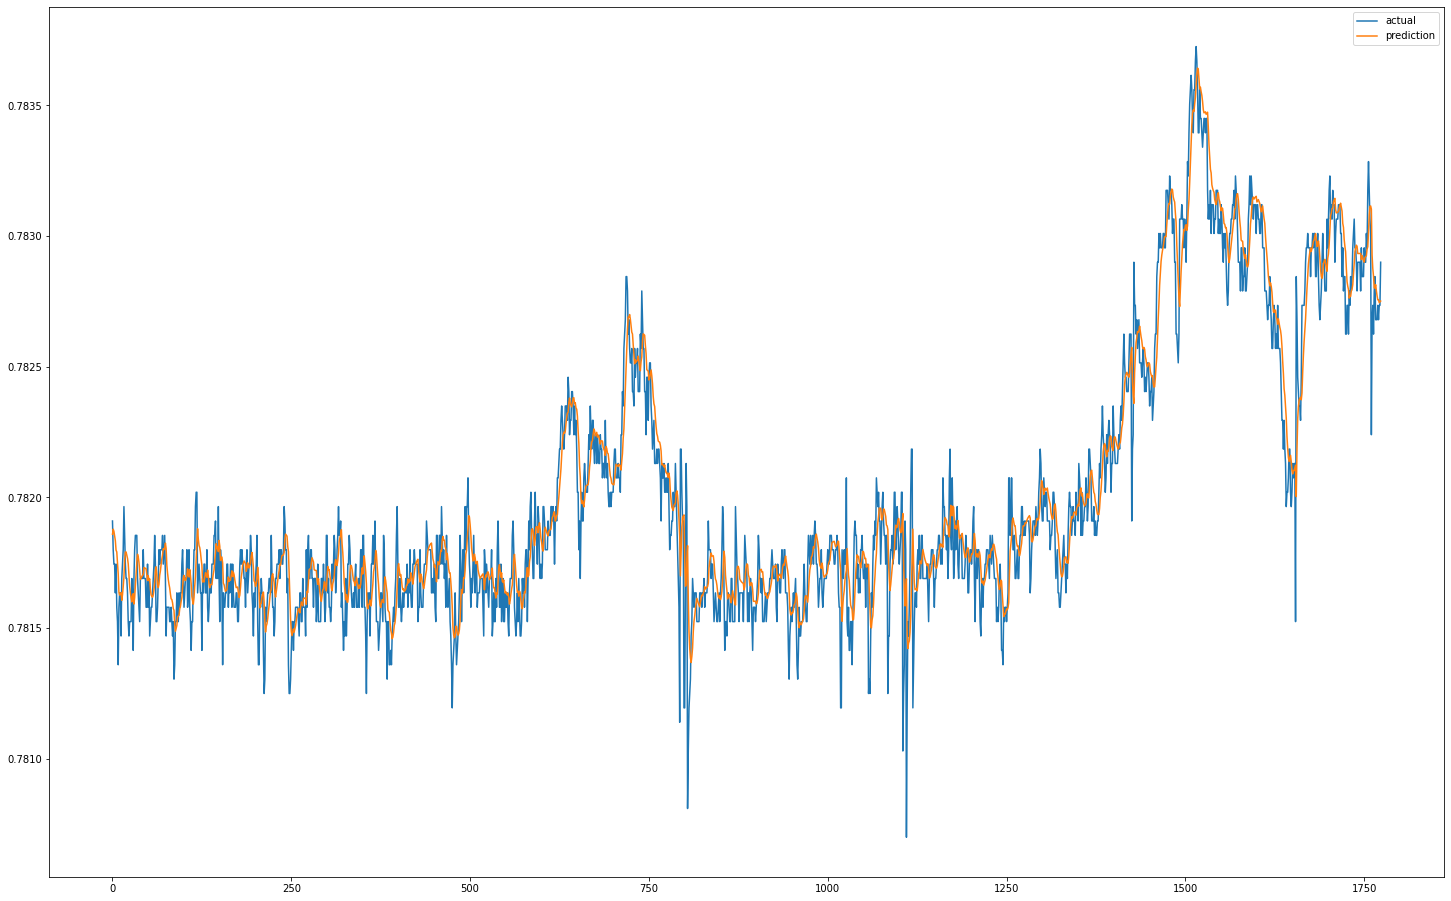

In [87]:

plt.figure(figsize=(25, 16))
plt.plot(test_label2, label='actual')
plt.plot(pred2, label='prediction')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot